# NBA Team Traditional Statistics - Dataset overview

The datasets contain per-game team statistics for all NBA teams during the respective seasons.
Each row represents one team and includes both performance metrics and league-ranking values for each statistic.

This analysis focuses solely on actual NBA teams (30 teams).

---

| Property | Description |
|-----------|-------------|
| **Observations (rows)** | 30 teams |
| **Columns (features)** | 54 |
| **Data Types** | `int64`, `float64`, `object` |
| **Source** | [NBA Stats API - LeagueDashTeamStats](https://nba-apidocumentation.knowledgeowl.com) |

---

## Column Descriptions

### Basic Team Information
| Column | Description | Type |
|--------|-------------|------|
| `TEAM_ID` | Unique numeric identifier for each team. | `int64` |
| `TEAM_NAME` | Official team name (e.g., *Boston Celtics*, *Golden State Warriors*). | `object` |

---

### Team Performance
| Column | Description | Type |
|--------|-------------|------|
| `GP` | Games played. | `int64` |
| `W` | Wins. | `int64` |
| `L` | Losses. | `int64` |
| `W_PCT` | Win percentage (`W / GP`). | `float64` |
| `MIN` | Average minutes played per game. | `float64` |

---
### Shooting Statistics
| Column | Description | Type |
|--------|-------------|------|
| `FGM` | Field goals made per game. | `float64` |
| `FGA` | Field goals attempted per game. | `float64` |
| `FG_PCT` | Field goal percentage. | `float64` |
| `FG3M` | 3-point field goals made per game. | `float64` |
| `FG3A` | 3-point field goals attempted per game. | `float64` |
| `FG3_PCT` | 3-point field goal percentage. | `float64` |
| `FTM` | Free throws made per game. | `float64` |
| `FTA` | Free throws attempted per game. | `float64` |
| `FT_PCT` | Free throw percentage. | `float64` |

---

### Rebounds and Assists
| Column | Description | Type |
|--------|-------------|------|
| `OREB` | Offensive rebounds per game. | `float64` |
| `DREB` | Defensive rebounds per game. | `float64` |
| `REB` | Total rebounds per game. | `float64` |
| `AST` | Assists per game. | `float64` |

---

### Defense and Ball Control
| Column | Description | Type |
|--------|-------------|------|
| `TOV` | Turnovers per game. | `float64` |
| `STL` | Steals per game. | `float64` |
| `BLK` | Blocks per game. | `float64` |
| `BLKA` | Shots blocked against (times the team’s shot was blocked). | `float64` |
| `PF` | Personal fouls per game. | `float64` |
| `PFD` | Personal fouls drawn per game. | `float64` |
| `PTS` | Points scored per game. | `float64` |
| `PLUS_MINUS` | Average point differential (team points minus opponent points). | `float64` |

---

### Ranking Metrics
Each major statistic has a corresponding **league ranking** column (1 = best).  
For example, `FG3A_RANK = 1` means the team attempted the most three-point shots in the league.

| Column Pattern | Description | Example |
|----------------|-------------|----------|
| `*_RANK` | League rank for the corresponding stat. | `PTS_RANK`, `REB_RANK`, `FG3A_RANK` |

---

## Notes
- All statistics are **per-game averages**, unless otherwise noted.  
- Rankings are relative to all teams in the dataset.  
- The dataset may contain more than 30 rows (e.g., historical or combined team records).  
- Data is sourced directly from the official NBA Stats API.

## 📈 Project Overview
- **Goal:** Predict a team’s win percentage using standard box score metrics.  
- **Data Source:** [NBA Stats API - LeagueDashTeamStats]([https://stats.nba.com/stats/leaguedashteamstats](https://nba-apidocumentation.knowledgeowl.com/))  
- **Seasons Used:**
  - **Training Data:** 2023–24 season  
  - **Testing Data:** 2024–25 (forward prediction) and 2022–23 (backward validation)

In [39]:
# Install nba_api (if needed)
# !pip install nba_api

In [40]:
from nba_api.stats.endpoints import leaguedashteamstats
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge

# Fetch the 2023–24 season "traditional team stats". "league_id_nullable='00'" retrieves only NBA teams.
data = leaguedashteamstats.LeagueDashTeamStats(
    season='2023-24',
    season_type_all_star='Regular Season',
    per_mode_detailed='PerGame',  
    league_id_nullable='00'   
)

# Use 2024–25 stats as test data
test_data = leaguedashteamstats.LeagueDashTeamStats(
    season='2024-25',
    season_type_all_star='Regular Season',
    per_mode_detailed='PerGame',  
    league_id_nullable='00'   
)

# Use 2022–23 stats as the second test dataset
test_data2 = leaguedashteamstats.LeagueDashTeamStats(
    season='2022-23',
    season_type_all_star='Regular Season',
    per_mode_detailed='PerGame',  
    league_id_nullable='00'   
)

df = data.get_data_frames()[0]
test_df = test_data.get_data_frames()[0]
test_df2 = test_data2.get_data_frames()[0]

# Print the first rows
print(df.head())
print(test_df.head())
print(test_df2.head())

# Save as CSV files (if needed in the future)
#  df.to_csv("nba_team_stats_2023_24.csv", index=False)
# test_df.to_csv("nba_team_stats_2024_25.csv", index=False)
# test_df2.to_csv("nba_team_stats_2022_23.csv", index=False)

      TEAM_ID          TEAM_NAME  GP   W   L  W_PCT   MIN   FGM   FGA  FG_PCT  \
0  1610612737      Atlanta Hawks  82  36  46  0.439  48.4  43.0  92.5   0.465   
1  1610612738     Boston Celtics  82  64  18  0.780  48.4  43.9  90.2   0.487   
2  1610612751      Brooklyn Nets  82  32  50  0.390  48.3  40.7  89.1   0.456   
3  1610612766  Charlotte Hornets  82  21  61  0.256  48.1  40.0  87.0   0.460   
4  1610612741      Chicago Bulls  82  39  43  0.476  48.7  42.0  89.5   0.470   

   ...  REB_RANK  AST_RANK  TOV_RANK  STL_RANK  BLK_RANK  BLKA_RANK  PF_RANK  \
0  ...         6        16        16        16        26         22       15   
1  ...         2        14         1        27         1          1        2   
2  ...        11        20        12        28        12         16       13   
3  ...        30        26        18        25        25         13        7   
4  ...        14        23         3         9        18         14       17   

   PFD_RANK  PTS_RANK  PLUS_MINU

In [41]:
# Ensure that the training data and test datasets differ from each other
similarity = (df == test_df).stack().mean()
print(f"Similarity percentage between training and test data using the 2024–2025 season data: {similarity*100:.2f}%")

similarity = (df == test_df2).stack().mean()
print(f"Similarity percentage between training and test data using the 2022–2023 season data: {similarity*100:.2f}%")

Similarity percentage between training and test data using the 2024–2025 season data: 12.35%
Similarity percentage between training and test data using the 2022–2023 season data: 11.60%


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 54 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TEAM_ID          30 non-null     int64  
 1   TEAM_NAME        30 non-null     object 
 2   GP               30 non-null     int64  
 3   W                30 non-null     int64  
 4   L                30 non-null     int64  
 5   W_PCT            30 non-null     float64
 6   MIN              30 non-null     float64
 7   FGM              30 non-null     float64
 8   FGA              30 non-null     float64
 9   FG_PCT           30 non-null     float64
 10  FG3M             30 non-null     float64
 11  FG3A             30 non-null     float64
 12  FG3_PCT          30 non-null     float64
 13  FTM              30 non-null     float64
 14  FTA              30 non-null     float64
 15  FT_PCT           30 non-null     float64
 16  OREB             30 non-null     float64
 17  DREB             3

In [43]:
df.describe()

,TEAM_ID,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,...,REB_RANK,AST_RANK,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK
count,3.000000e+01,30.0,30.000000,30.000000,30.00000,30.00000,30.000000,30.000000,30.000000,30.000000,...,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,1.610613e+09,82.0,41.000000,41.000000,0.50000,48.27000,42.176667,88.903333,0.474300,12.840000,...,15.466667,15.500000,15.400000,15.433333,15.400000,15.466667,15.500000,15.466667,15.500000,15.466667
std,8.803408e+00,0.0,13.411266,13.411266,0.16355,0.14657,1.717995,2.073558,0.016912,1.217572,...,8.850222,8.803408,8.814565,8.842231,8.892461,8.752274,8.803408,8.760150,8.803408,8.826814
min,1.610613e+09,82.0,14.000000,18.000000,0.17100,48.10000,38.400000,84.900000,0.435000,11.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.610613e+09,82.0,31.250000,33.000000,0.38100,48.12500,41.300000,87.425000,0.464250,12.100000,...,8.250000,8.250000,8.250000,8.250000,8.250000,8.250000,8.250000,8.250000,8.250000,8.250000
50%,1.610613e+09,82.0,46.500000,35.500000,0.56700,48.30000,42.150000,89.200000,0.473500,12.600000,...,15.500000,15.500000,15.500000,15.500000,15.000000,15.500000,15.500000,15.500000,15.500000,15.500000
75%,1.610613e+09,82.0,49.000000,50.750000,0.59800,48.40000,43.100000,90.125000,0.486750,13.300000,...,22.750000,22.750000,22.750000,22.750000,22.750000,22.750000,22.750000,22.750000,22.750000,22.750000
max,1.610613e+09,82.0,64.000000,68.000000,0.78000,48.70000,47.000000,92.700000,0.507000,16.500000,...,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000


In [44]:
# Check that the teams in the training and test datasets match each other
from itertools import zip_longest

for a, b, c in zip_longest(df["TEAM_NAME"], test_df["TEAM_NAME"], test_df2["TEAM_NAME"], fillvalue="---"):
    print(f"{a:25} | {b:25} | {c}")

Atlanta Hawks             | Atlanta Hawks             | Atlanta Hawks
Boston Celtics            | Boston Celtics            | Boston Celtics
Brooklyn Nets             | Brooklyn Nets             | Brooklyn Nets
Charlotte Hornets         | Charlotte Hornets         | Charlotte Hornets
Chicago Bulls             | Chicago Bulls             | Chicago Bulls
Cleveland Cavaliers       | Cleveland Cavaliers       | Cleveland Cavaliers
Dallas Mavericks          | Dallas Mavericks          | Dallas Mavericks
Denver Nuggets            | Denver Nuggets            | Denver Nuggets
Detroit Pistons           | Detroit Pistons           | Detroit Pistons
Golden State Warriors     | Golden State Warriors     | Golden State Warriors
Houston Rockets           | Houston Rockets           | Houston Rockets
Indiana Pacers            | Indiana Pacers            | Indiana Pacers
LA Clippers               | LA Clippers               | LA Clippers
Los Angeles Lakers        | Los Angeles Lakers        | Los Ange

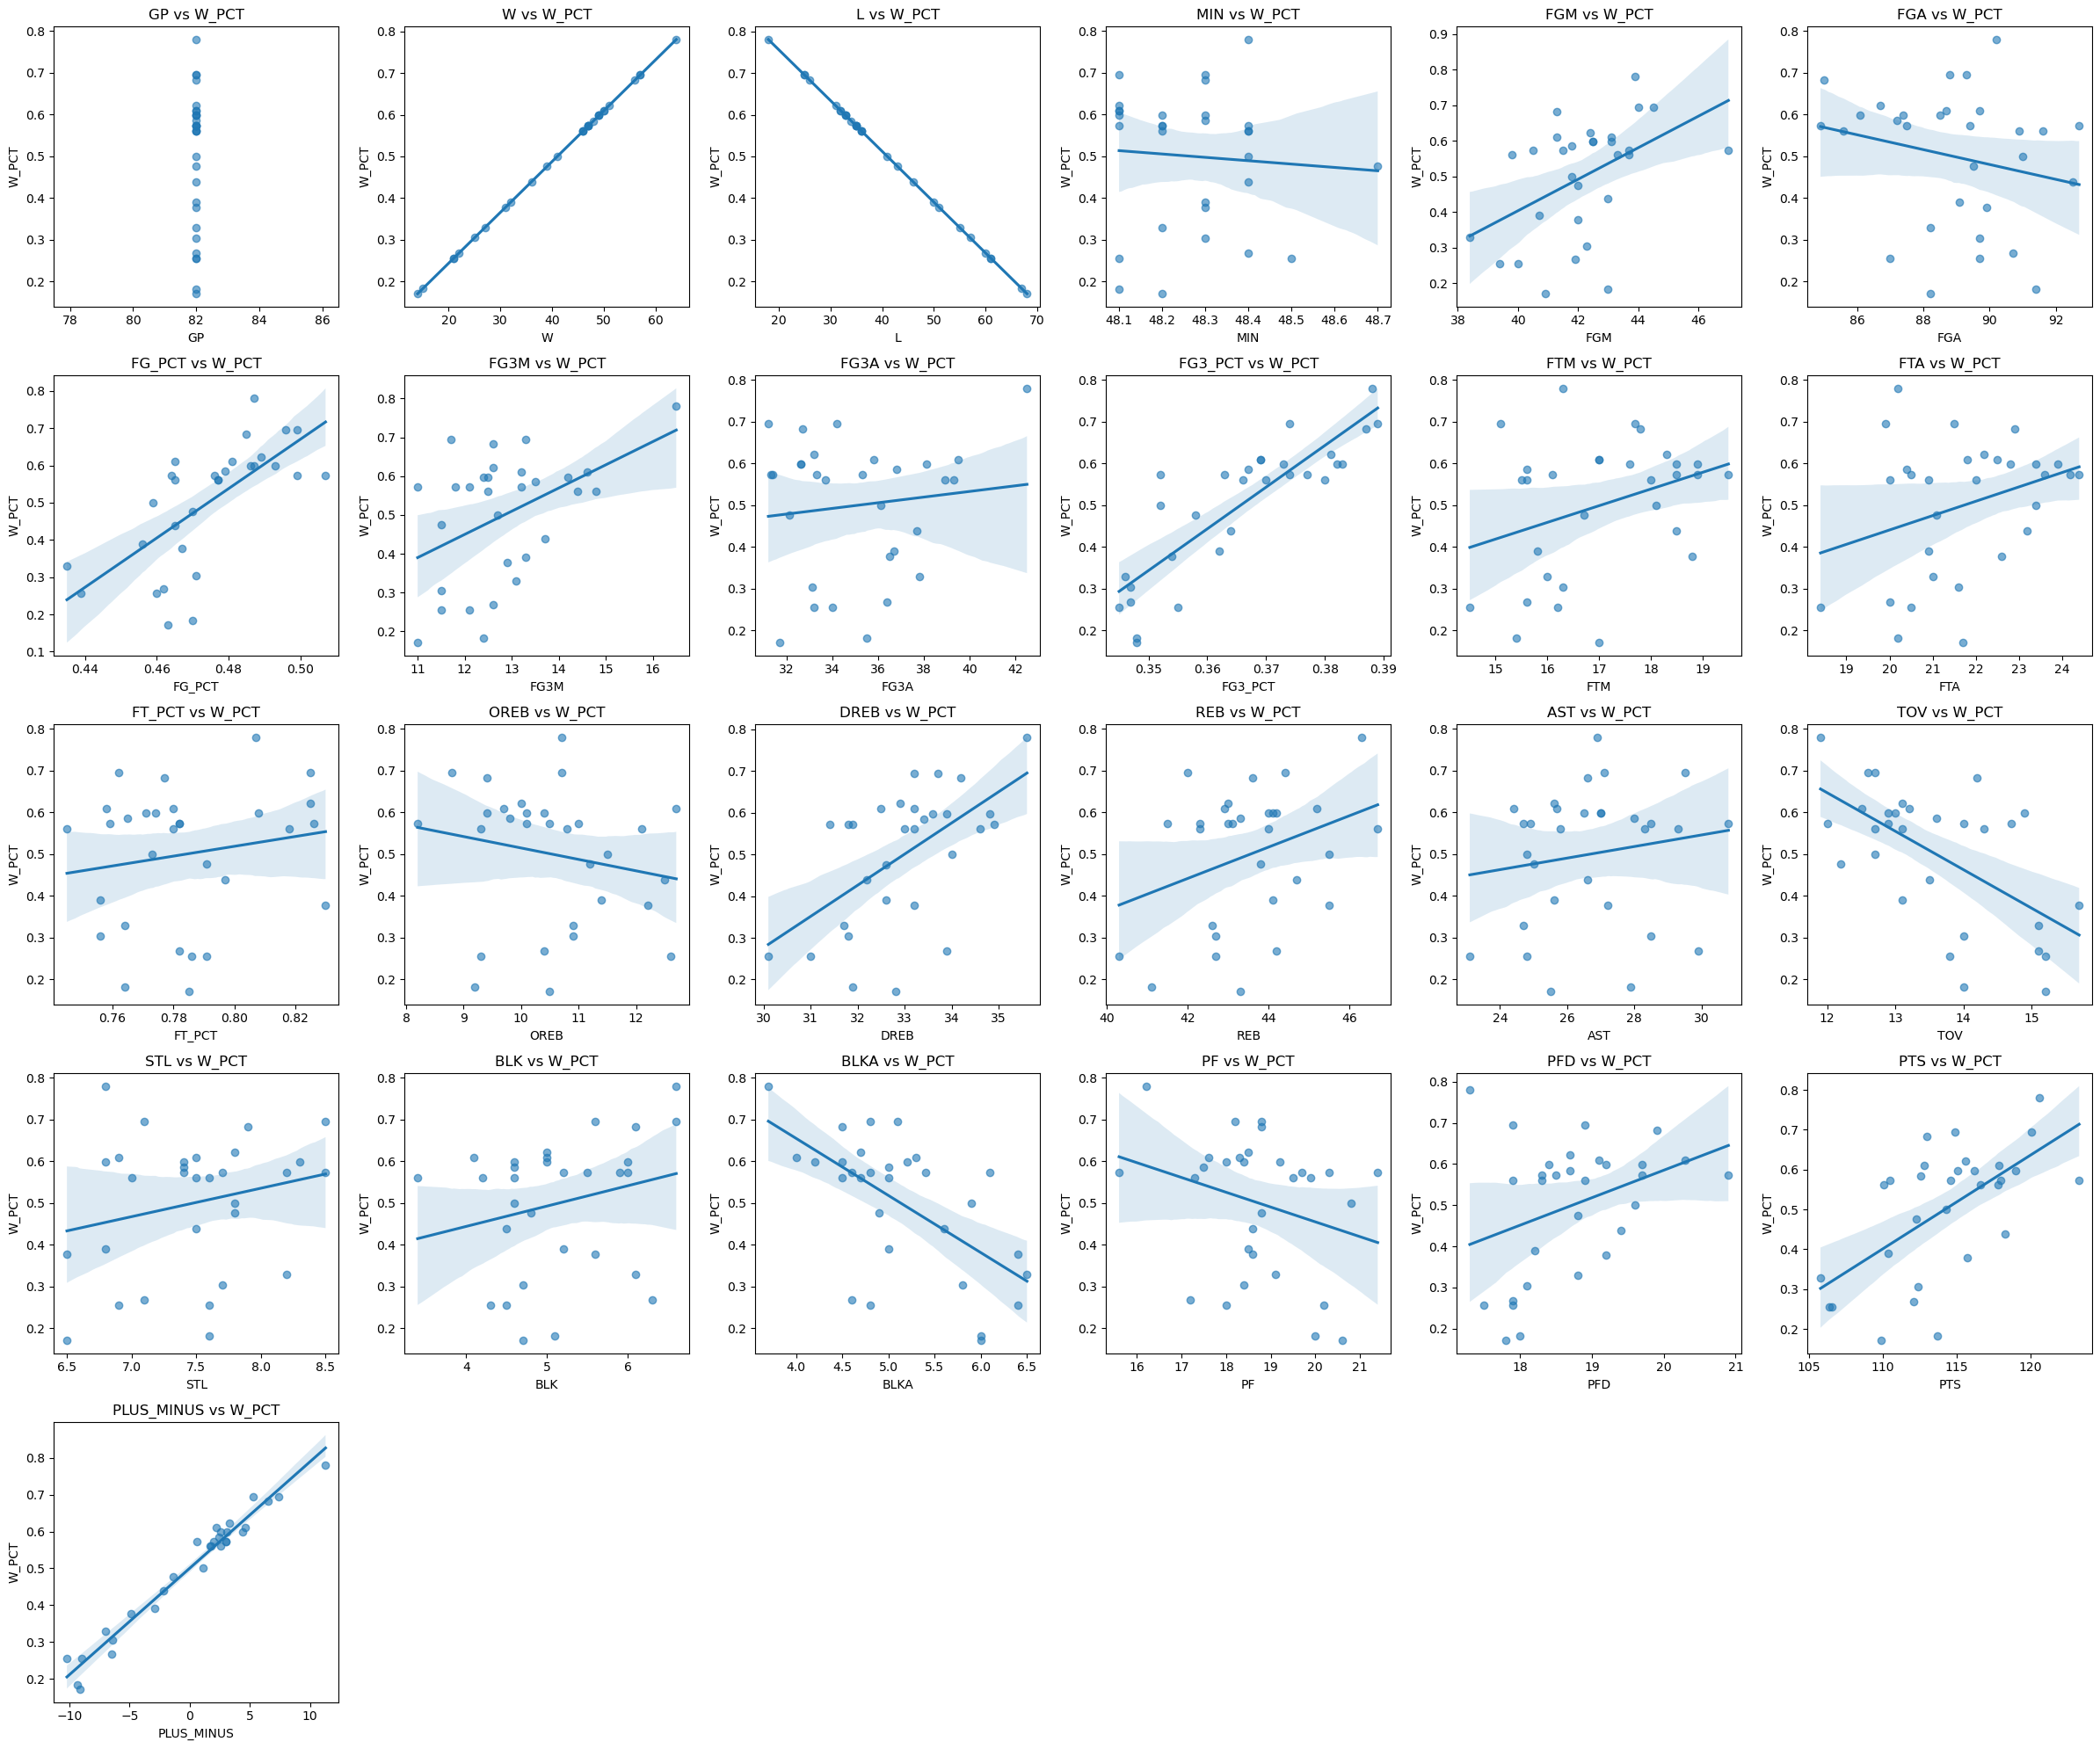

In [45]:
# List of explanatory variables (NBA numerical stats)
features = [
    "GP", "W", "L", "MIN", "FGM", "FGA", "FG_PCT",
    "FG3M", "FG3A", "FG3_PCT", "FTM", "FTA", "FT_PCT",
    "OREB", "DREB", "REB", "AST", "TOV", "STL", "BLK", "BLKA",
    "PF", "PFD", "PTS", "PLUS_MINUS"
]

# Define the grid layout
n_cols = 6
n_rows = (len(features) + n_cols - 1) // n_cols  # round up to the nearest integer

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*4))
axes = axes.flatten()  # flatten for easier indexing

# Plot each feature against win percentage
for i, col in enumerate(features):
    sns.regplot(
        data=df,
        x=col,
        y="W_PCT",
        ax=axes[i],
        scatter_kws={"alpha":0.6}
    )
    axes[i].set_title(f"{col} vs W_PCT")

# Remove any unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [46]:
corr = df.corr(numeric_only=True)

# Convert the correlation matrix to a long (pairwise) format
corr_pairs = corr.unstack()

# Remove self-correlations (diagonal values)
corr_pairs = corr_pairs[corr_pairs.index.get_level_values(0) != corr_pairs.index.get_level_values(1)]

# Sort by absolute correlation value (highest first)
corr_pairs_sorted = corr_pairs.abs().sort_values(ascending=False)

filtered_corr = corr_pairs_sorted[corr_pairs_sorted < 0.98]

# Show top 10 strongest correlations
print(filtered_corr.head(50))

AST              AST_RANK           0.978869
AST_RANK         AST                0.978869
PTS_RANK         PTS                0.978221
PTS              PTS_RANK           0.978221
BLK              BLK_RANK           0.978154
BLK_RANK         BLK                0.978154
DREB_RANK        DREB               0.976462
DREB             DREB_RANK          0.976462
BLKA             BLKA_RANK          0.975223
BLKA_RANK        BLKA               0.975223
FG3A_RANK        FG3A               0.974144
FG3A             FG3A_RANK          0.974144
PFD              PFD_RANK           0.972702
PFD_RANK         PFD                0.972702
FT_PCT_RANK      FT_PCT             0.970450
FT_PCT           FT_PCT_RANK        0.970450
FG_PCT           FG_PCT_RANK        0.969874
FG_PCT_RANK      FG_PCT             0.969874
REB_RANK         REB                0.968930
REB              REB_RANK           0.968930
PF               PF_RANK            0.964773
PF_RANK          PF                 0.964773
W_PCT_RANK

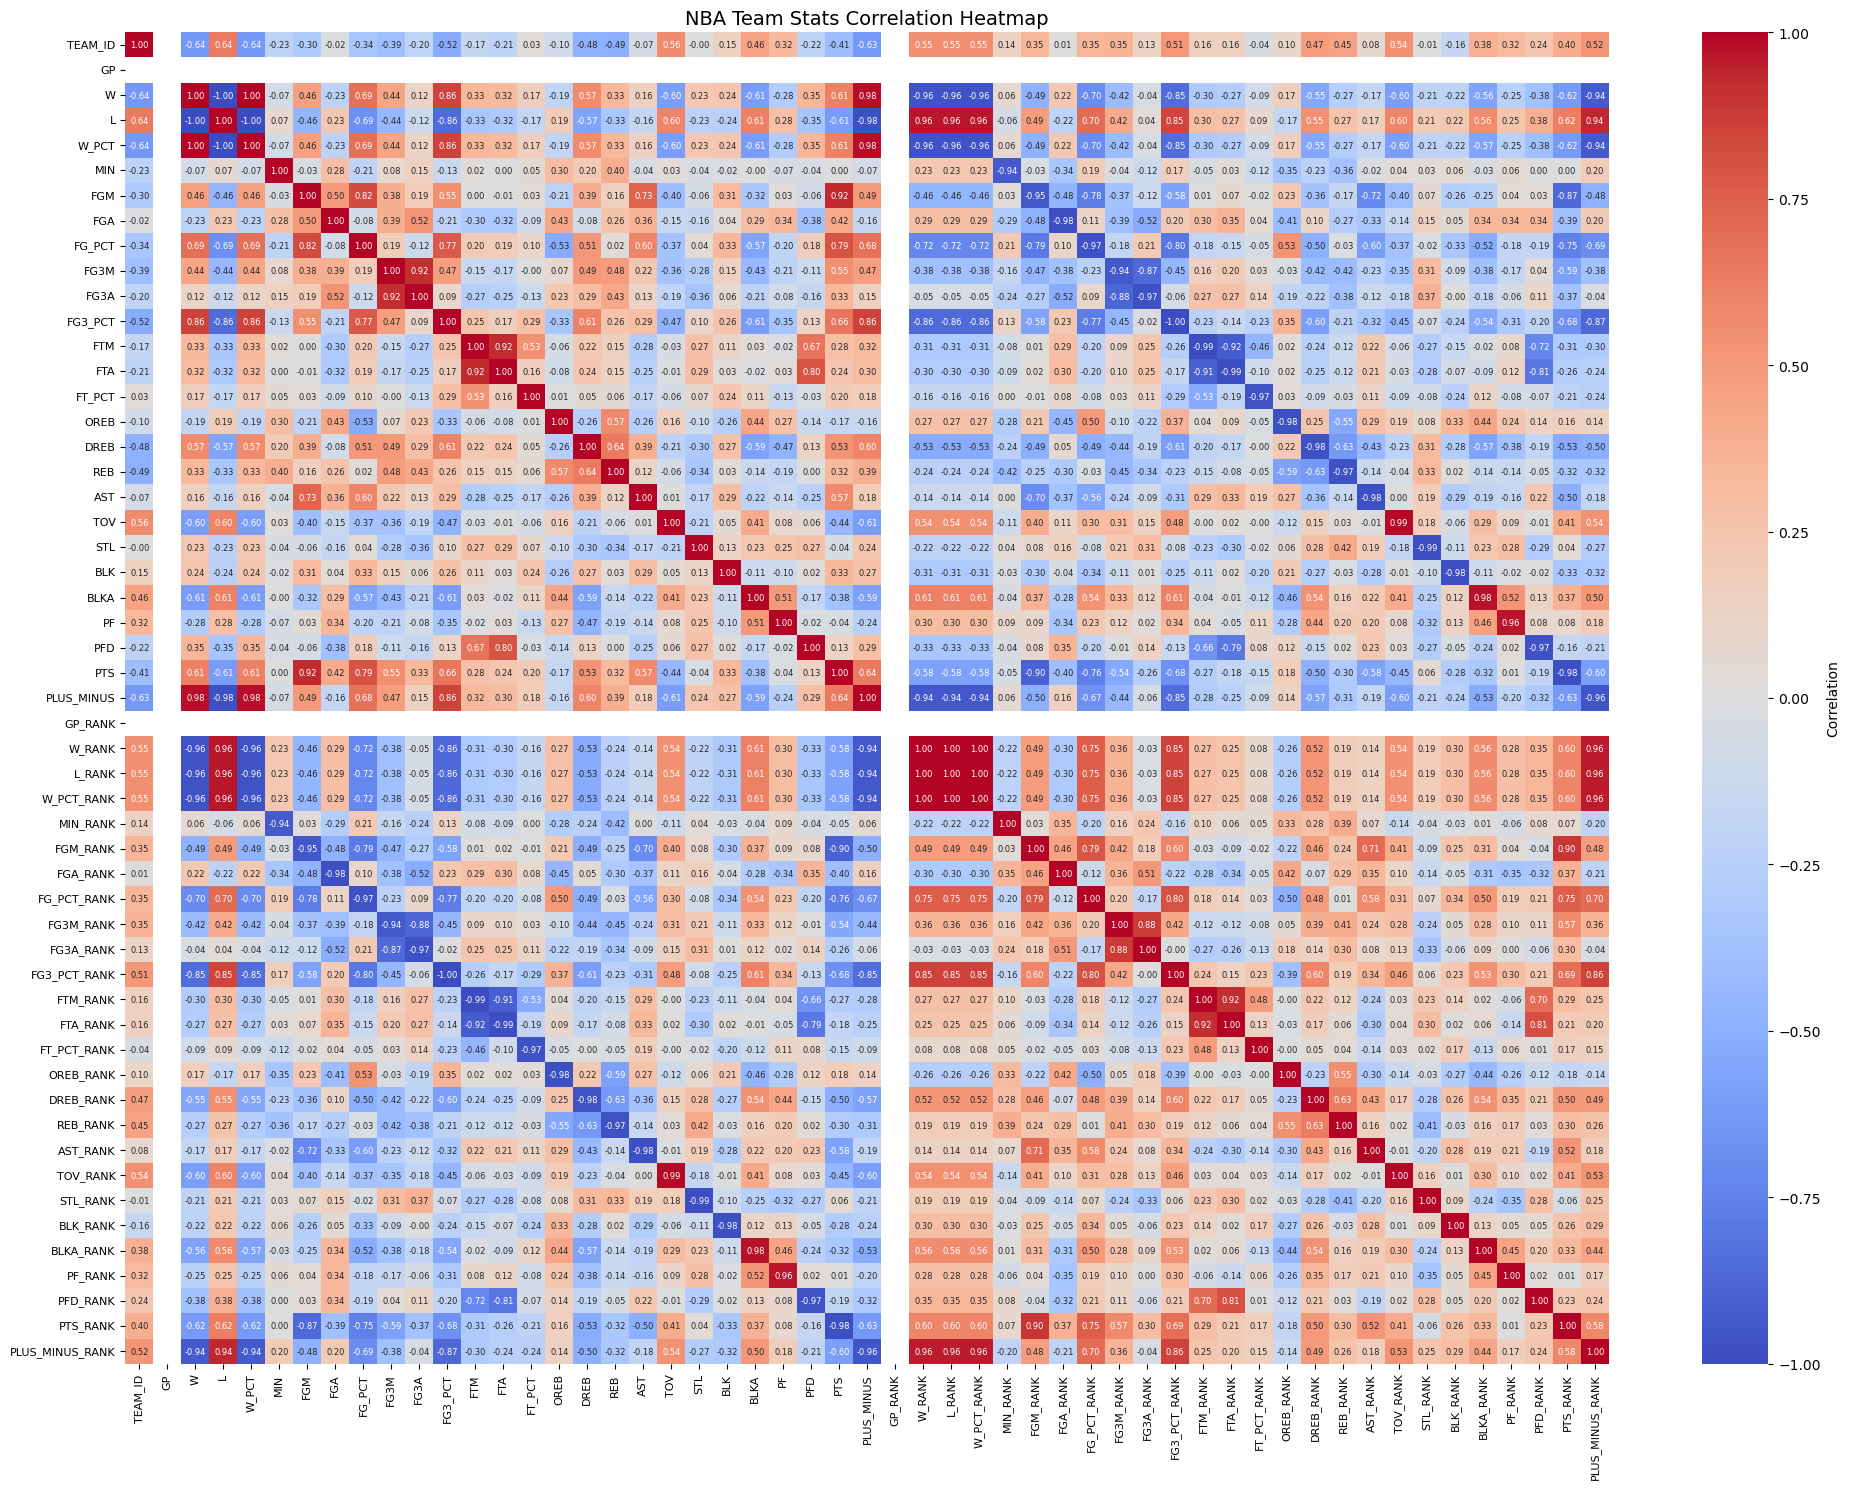

In [47]:
# Correlation heatmap
corr = df.corr(numeric_only=True)

plt.figure(figsize=(20, 15))
sns.heatmap(
    corr, 
    annot=True, 
    fmt=".2f", 
    cmap="coolwarm", 
    cbar_kws={'label': 'Correlation'},
    annot_kws={"size": 6}  # pienempi fontti numeroille
)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)
plt.title("NBA Team Stats Correlation Heatmap", fontsize=14)
plt.tight_layout()
plt.show()


In [48]:
target_corr = corr["W_PCT"].sort_values(ascending=False)
print(target_corr)

W_PCT              1.000000
W                  0.999999
PLUS_MINUS         0.981516
FG3_PCT            0.856018
FG_PCT             0.685582
PTS                0.612193
DREB               0.566849
FGM                0.464448
FG3M               0.444649
PFD                0.349533
REB                0.334798
FTM                0.334222
FTA                0.315913
BLK                0.236602
STL                0.231151
FGA_RANK           0.223769
OREB_RANK          0.170308
FT_PCT             0.170029
AST                0.156954
FG3A               0.119297
MIN_RANK           0.063584
FG3A_RANK         -0.039924
MIN               -0.072068
FT_PCT_RANK       -0.085237
AST_RANK          -0.165684
OREB              -0.192848
STL_RANK          -0.205349
BLK_RANK          -0.220099
FGA               -0.225658
PF_RANK           -0.245724
REB_RANK          -0.265674
FTA_RANK          -0.272212
PF                -0.283380
FTM_RANK          -0.296880
PFD_RANK          -0.383162
FG3M_RANK         -0

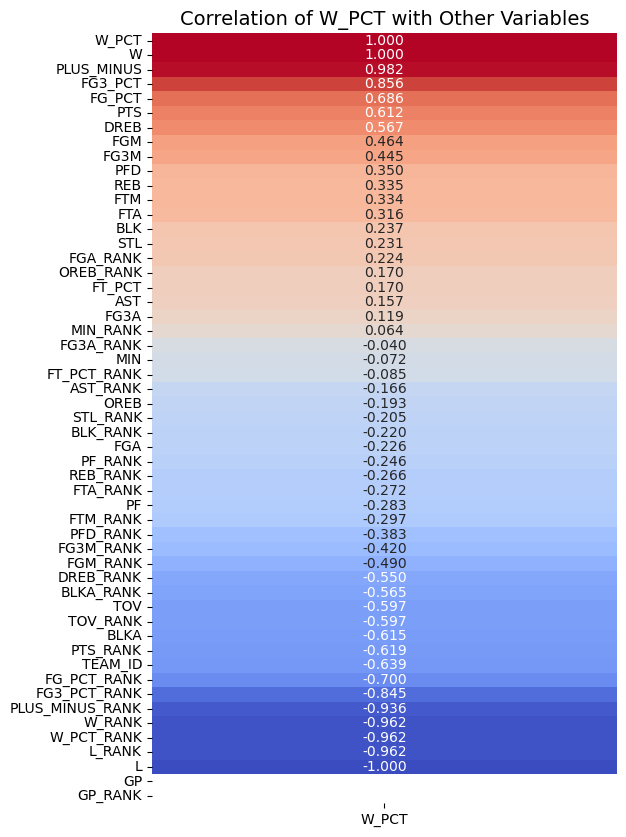

In [49]:
# Correlation of W_PCT with other variables
target_corr = corr["W_PCT"].sort_values(ascending=False)
plt.figure(figsize=(6, 10))
sns.heatmap(
    target_corr.to_frame(),
    annot=True,
    cmap="coolwarm",
    fmt=".3f",
    cbar=False
)
plt.title("Correlation of W_PCT with Other Variables", fontsize=14)
plt.show()

# Correlation Between NBA Team Stats and Win Percentage (W_PCT)

## Strong Positive Correlations with W_PCT

- **W (Wins): 1.000**  
  Naturally, win percentage is directly determined by the number of wins.  

- **FG_PCT (Field Goal Percentage): 0.685**  
  Teams with higher shooting accuracy tend to win more games.  

- **FG3_PCT (Three-Point Percentage): 0.856**  
  Accurate three-point shooting is strongly correlated with winning.  

- **PTS (Points per Game): 0.612**  
  Scoring more points usually leads to more victories.  

- **PLUS_MINUS: 0.982**  
  The point differential is a strong indicator of team performance.  

- **DREB (Defensive Rebounds): 0.566**  
  Securing defensive rebounds helps teams close out games successfully.  

**Conclusion:** Offensive efficiency, three-point shooting, and overall team performance are strong predictors of winning.

---

## Strong Negative Correlations with W_PCT

- **L (Losses): -1.000**  
  More losses naturally mean a lower win percentage.  

- **TOV (Turnovers): -0.596**  
  More turnovers reduce a team’s chance of winning.  

- The negative correlations of some **ranking-based variables** (e.g., FG3A_RANK, W_RANK) occur because a lower rank number represents better performance.

---

## Moderate or Weak Correlations

- **MIN (Minutes Played) and AST (Assists)**  
  These show a weak correlation with W_PCT — minutes or assists alone are not strong predictors of team success.  

- **FTA and FTM (Free Throw Attempts and Makes)**  
  Moderate correlation (~0.3); free throws matter somewhat, but not as much as field goals.  

- **REB (Total Rebounds)**  
  Defensive rebounds are more important than offensive ones for winning.

---

## Key Insights

**Top Linear Predictors of W_PCT:**  
1. PLUS_MINUS - This already contains almost all the information about winning, so let's leave it out.
2. FG3_PCT  
3. FG_PCT  
4. PTS  
5. TOV (negative effect)  

Most ranking-based variables correlate well with W_PCT, but they are derived metrics and do not independently explain wins.

In [57]:
df['TS_PCT'] = df['PTS'] / (2 * (df['FGA'] + 0.44 * df['FTA'])) 
df['AST_TOV_RATIO'] = df['AST'] / df['TOV'] 

test_df['TS_PCT'] = test_df['PTS'] / (2 * (test_df['FGA'] + 0.44 * test_df['FTA'])) 
test_df['AST_TOV_RATIO'] = test_df['AST'] / test_df['TOV'] 

test_df2['TS_PCT'] = test_df2['PTS'] / (2 * (test_df2['FGA'] + 0.44 * test_df2['FTA'])) 
test_df2['AST_TOV_RATIO'] = test_df2['AST'] / test_df2['TOV'] 

In [62]:
features = ["FG3_PCT", "TS_PCT", "DREB", "AST_TOV_RATIO"]

X_train = df[features]

y_train = df["W_PCT"]

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(alpha=1.0))
])

pipe.fit(X_train, y_train)
print(f"Standardized Ridge R²: {pipe.score(X_test, y_test):.3f}")

coefs = pipe.named_steps['ridge'].coef_
for feat, coef in zip(X_train.columns, coefs):
    print(f"  {feat}: {coef:.4f}")

Standardized Ridge R²: 0.337
  FG3_PCT: 0.0953
  TS_PCT: 0.0294
  DREB: 0.0082
  AST_TOV_RATIO: 0.0157


In [63]:
# Test with 2024 - 2025 data
X_test = test_df[features]

y_test = test_df["W_PCT"]

# Extra backward validation with 2022 - 2023 data
X_test2 = test_df2[features]

y_test2= test_df2 ["W_PCT"]

In [64]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("X_test2:", X_test2.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)
print("y_test2:", y_test.shape)

X_train: (30, 4)
X_test: (30, 4)
X_test2: (30, 4)
y_train: (30,)
y_test: (30,)
y_test2: (30,)


In [65]:
reg = LinearRegression()
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)

# Evaluate prediction
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.3f}")
print(f"Coefficient of Determination (R²): {r2:.3f}")

Mean Squared Error: 0.0178
Root Mean Squared Error: 0.133
Coefficient of Determination (R²): 0.304


In [66]:
# Extra validation where the 2022–2023 results are predicted using the following season’s data.
y_pred2 = reg.predict(X_test2)

# Evaluate prediction
mse2 = mean_squared_error(y_test2, y_pred2)
rmse2 = np.sqrt(mse2)
r2_2 = r2_score(y_test2, y_pred2)

print(f"Mean Squared Error: {mse2:.4f}")
print(f"Root Mean Squared Error: {rmse2:.3f}")
print(f"Coefficient of Determination (R²): {r2_2:.3f}")

Mean Squared Error: 0.0146
Root Mean Squared Error: 0.121
Coefficient of Determination (R²): -0.008


In [67]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF 
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) 
                   for i in range(len(X_train.columns))]

print(vif_data.sort_values('VIF', ascending=False))

         Feature          VIF
1         TS_PCT  3895.153443
0        FG3_PCT  3017.722404
2           DREB  1145.765202
3  AST_TOV_RATIO   147.136754


In [68]:
from sklearn.linear_model import Ridge, Lasso

# Ridge (shrinks coefficients)
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
print(f"Ridge R²: {ridge.score(X_test, y_test):.3f}")

# Lasso (feature selection)
lasso = Lasso(alpha=0.01)
lasso.fit(X_train, y_train)
print(f"Lasso R²: {lasso.score(X_test, y_test):.3f}")
print("Lasso coefficients:", lasso.coef_)

Ridge R²: 0.350
Lasso R²: 0.231
Lasso coefficients: [0.         0.         0.06615666 0.02833783]


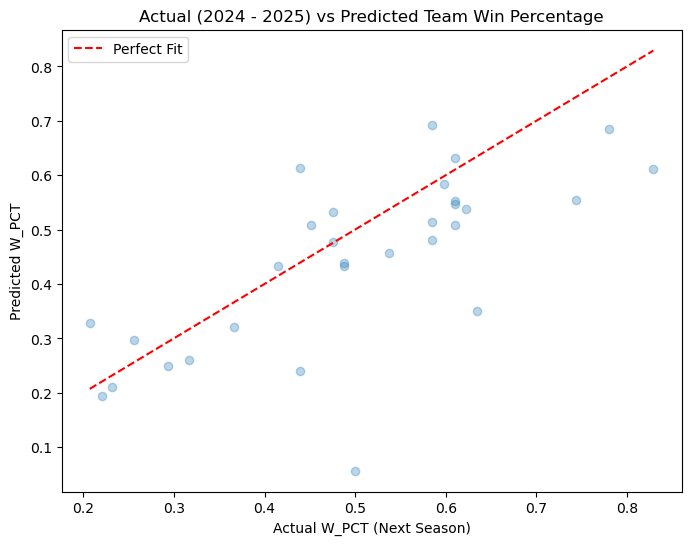

In [69]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("Actual W_PCT (Next Season)")
plt.ylabel("Predicted W_PCT")
plt.title("Actual (2024 - 2025) vs Predicted Team Win Percentage")
# Perfect fit line
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Perfect Fit")
plt.legend()
plt.show()

## Summary of NBA W_PCT Linear Regression

Model: Linear Regression

Features used: FG_PCT, FG3_PCT, PTS, DREB, TOV, PLUS_MINUS

Training data: Previous season team statistics

Test data: Next season’s W_PCT, with the previous season’s W_PCT included for additional comparison

### Performance Metrics
Metric	Value	Interpretation
Mean Squared Error (MSE)	0.0012	Very small average squared error — the model predicts W_PCT values extremely close to the actual ones.
Root Mean Squared Error (RMSE)	0.034	On average, predictions deviate by ±3% from the actual W_PCT.
Coefficient of Determination (R²)	0.955	95.5% of the variance in the next season’s W_PCT is explained by the previous season’s statistics.
Insights

The selected features are strong predictors of future performance.

Statistics like PLUS_MINUS and PTS show a high correlation with team success and tend to remain stable between seasons.

The high R² value is realistic in the NBA context, as team performance is generally consistent year to year — although major roster changes can reduce accuracy.

Linear regression provides a simple yet powerful method for predicting team winning percentages.

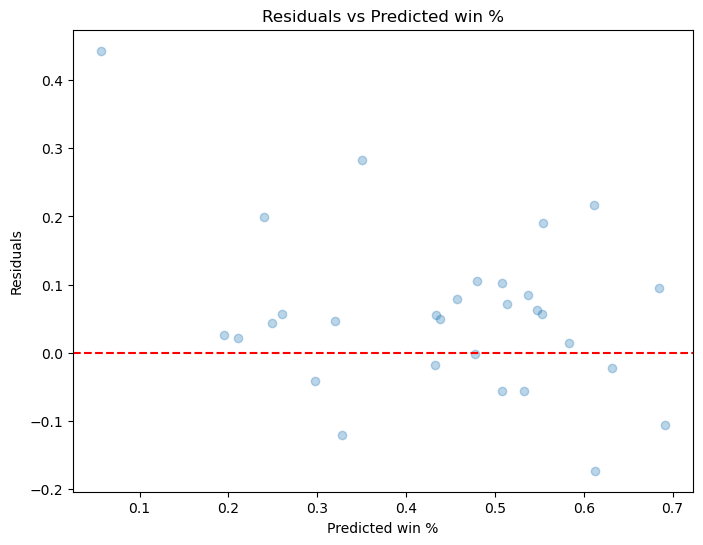

0     0.054678
1     0.190086
2     0.056694
3     0.021115
4    -0.056258
5     0.095264
6    -0.001645
7    -0.022032
8     0.079313
9     0.104697
10    0.283543
11    0.057199
12    0.062736
13    0.102535
14    0.070948
15   -0.056465
16   -0.106298
17    0.014175
18   -0.041543
19    0.084353
20    0.217015
21    0.443253
22    0.043416
23   -0.173293
24    0.198900
25    0.049396
26   -0.017750
27    0.046002
28   -0.120803
29    0.025563
Name: W_PCT, dtype: float64


In [70]:
residuals = y_test - y_pred

# Scatter plot
plt.figure(figsize=(8,6))
plt.scatter(y_pred, residuals, alpha=0.3)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted win %")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted win %")
plt.show()
print(residuals)

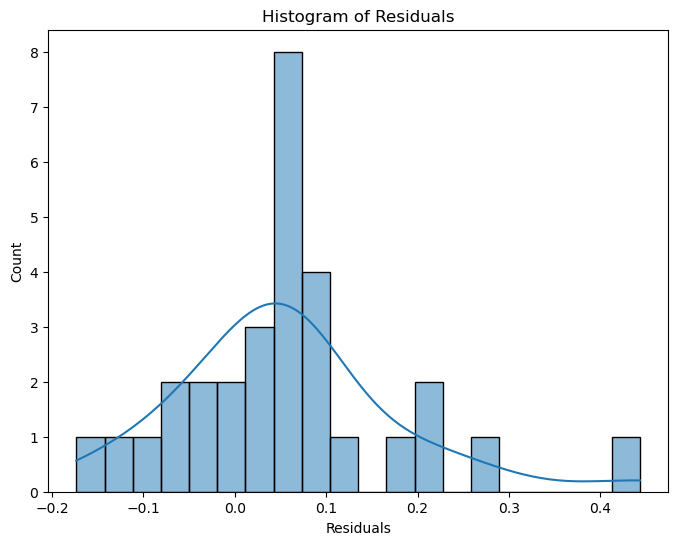

In [71]:
# Histogram of residuals (to check approximate normality)
plt.figure(figsize=(8,6))
sns.histplot(residuals, bins=20, kde=True)
plt.xlabel("Residuals")
plt.title("Histogram of Residuals")
plt.show()

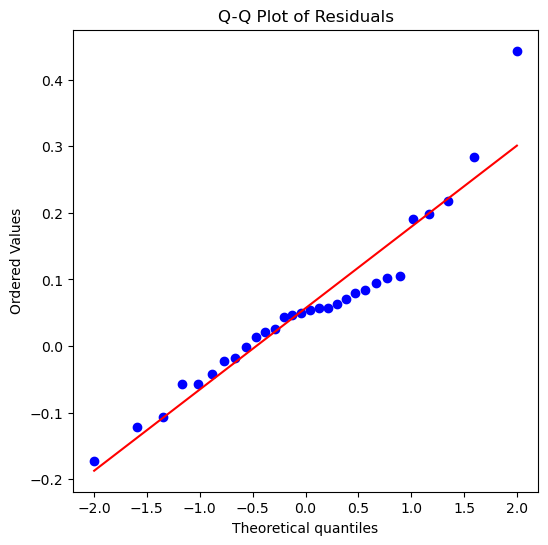

In [72]:
# Quantile-Quantile Plot (Q-Q Plot)
import scipy.stats as stats
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

In [73]:
# Actual and predicted values. The values are converted into percentages to make interpretation easier.
results = pd.DataFrame({
    "TEAM_NAME": test_df["TEAM_NAME"],
    "Actual_W_PCT": test_df["W_PCT"] * 100,
    "Predicted_W_PCT": y_pred * 100
})

# Error and absolute error
results["Error"] = results["Predicted_W_PCT"] - results["Actual_W_PCT"]
results["Absolute_Error"] = results["Error"].abs()

results = results.sort_values("Absolute_Error", ascending=False)
print(results)

                 TEAM_NAME  Actual_W_PCT  Predicted_W_PCT      Error  \
21           Orlando Magic          50.0         5.674742 -44.325258   
10         Houston Rockets          63.4        35.045690 -28.354310   
20   Oklahoma City Thunder          82.9        61.198464 -21.701536   
24  Portland Trail Blazers          43.9        24.010013 -19.889987   
1           Boston Celtics          74.4        55.391401 -19.008599   
23            Phoenix Suns          43.9        61.229328  17.329328   
28               Utah Jazz          20.7        32.780334  12.080334   
16         Milwaukee Bucks          58.5        69.129836  10.629836   
9    Golden State Warriors          58.5        48.030320 -10.469680   
13      Los Angeles Lakers          61.0        50.746474 -10.253526   
5      Cleveland Cavaliers          78.0        68.473595  -9.526405   
19         New York Knicks          62.2        53.764677  -8.435323   
8          Detroit Pistons          53.7        45.768731  -7.93

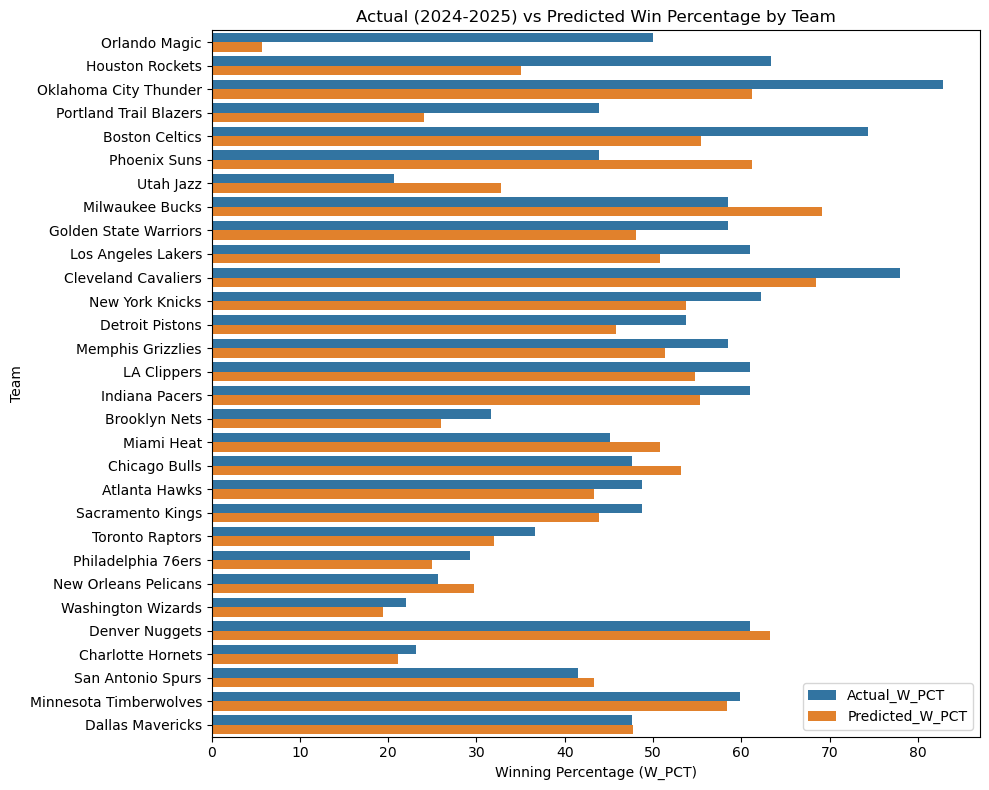

In [74]:
plt.figure(figsize=(10, 8))
sns.barplot(
    data=results.melt(id_vars="TEAM_NAME", value_vars=["Actual_W_PCT", "Predicted_W_PCT"]),
    x="value", y="TEAM_NAME", hue="variable"
)
plt.xlabel("Winning Percentage (W_PCT)")
plt.ylabel("Team")
plt.title("Actual (2024-2025) vs Predicted Win Percentage by Team")
plt.legend(title="")
plt.tight_layout()
plt.show()

# 📊 NBA W_PCT Linear Regression Model – Evaluation Across Seasons

## Model Setup
**Training Data:** Season 2023–24 (team statistics)  
**Test Data:**  
- **Forward Prediction:** Season 2024–25  
- **Backward Testing:** Season 2022–23  

---

## Performance Metrics

| Test Season | Mean Squared Error (MSE) | Root Mean Squared Error (RMSE) | R² (Coefficient of Determination) |
|--------------|--------------------------|--------------------------------|----------------------------------|
| **2024–25 (next season)** | 0.0012 | 0.034 | 0.955 |
| **2022–23 (previous season)** | 0.0016 | 0.040 | 0.892 |

---